# Chapter 3 - Linear Regression

In [126]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

### Load Datasets
Datasets available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [127]:
advertising = pd.read_csv('Data/Advertising.csv', usecols=[1,2,3,4])
advertising.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
Radio        200 non-null float64
Newspaper    200 non-null float64
Sales        200 non-null float64
dtypes: float64(4)
memory usage: 7.8 KB


In [128]:
credit = pd.read_csv('Data/Credit.csv', usecols=list(range(1,12)))
credit['Student2'] = credit.Student.map({'No':0, 'Yes':1})
credit.head(3)

    Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
0   14.891   3606     283      2   34         11    Male      No     Yes   
1  106.025   6645     483      3   82         15  Female     Yes     Yes   
2  104.593   7075     514      4   71         11    Male      No      No   

   Ethnicity  Balance  Student2  
0  Caucasian      333         0  
1      Asian      903         1  
2      Asian      580         0  

In [129]:
auto = pd.read_csv('Data/Auto.csv', na_values='?').dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 29.1+ KB


### Figure 3.1 - Least squares fit

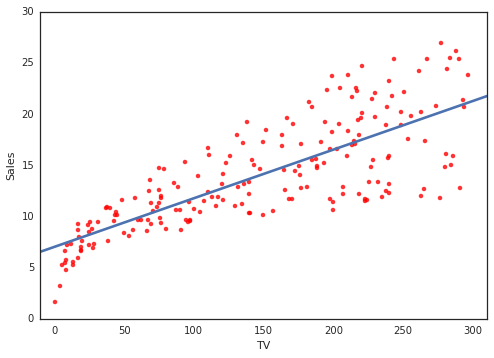

In [130]:
sns.regplot(advertising.TV, advertising.Sales, order=1, ci=None, scatter_kws={'color':'r'})
plt.xlim(-10,310)
plt.ylim(ymin=0);

### Figure 3.2 - Regression coefficients - RSS
Note that the text in the book describes the coefficients based on uncentered data, whereas the plot shows the model based on centered data. The latter is visually more appealing for explaining the concept of a minimum RSS. I think that, in order not to confuse the reader, the values on the axis of the B0 coefficients have been changed to correspond with the text. The axes on the plots below are unaltered.

In [131]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()

X = scale(advertising.TV, with_mean=True, with_std=False).reshape(-1,1)
y = advertising.Sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

14.0225
[ 0.04753664]


In [132]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size,B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.reshape(-1,1))**2)/1000
min_rss

2.1025305831313514

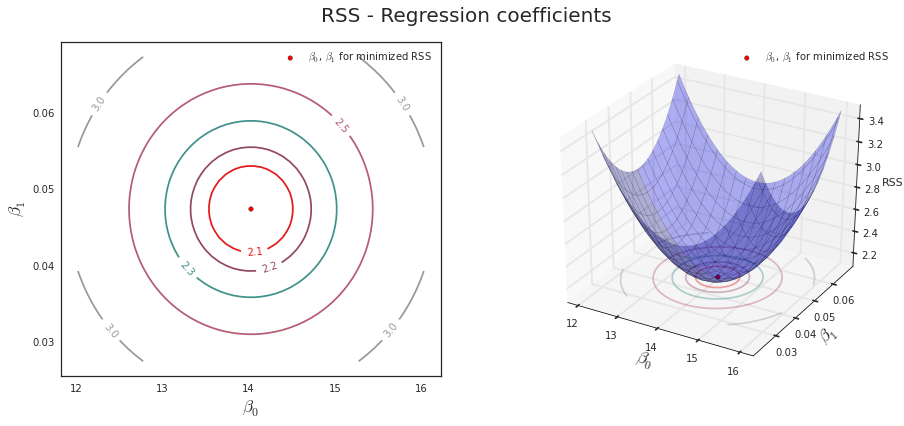

In [133]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=cm.Set1, alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

### Confidence interval on page 67 & Table 3.1 & 3.2 (Statsmodels) 

In [134]:
est = smf.ols('Sales ~ TV', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,7.0326,0.458,15.360,0.000,6.130 7.935
TV,0.0475,0.003,17.668,0.000,0.042 0.053


In [135]:
# RSS with regression coefficients
((advertising.Sales - (est.params[0] + est.params[1]*advertising.TV))**2).sum()/1000

2.102530583131352

### Table 3.1 & 3.2 (Scikit-learn)

In [136]:
regr = skl_lm.LinearRegression()

X = advertising.TV.reshape(-1,1)
y = advertising.Sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

7.03259354913
[ 0.04753664]


In [137]:
Sales_pred = regr.predict(X)

In [138]:
r2_score(y, Sales_pred)

0.61187505085007099

### Table 3.3 (Statsmodels)

In [139]:
est = smf.ols('Sales ~ Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,9.3116,0.563,16.542,0.000,8.202 10.422
Radio,0.2025,0.020,9.921,0.000,0.162 0.243


In [140]:
est = smf.ols('Sales ~ Newspaper', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,12.3514,0.621,19.876,0.000,11.126 13.577
Newspaper,0.0547,0.017,3.300,0.001,0.022 0.087


### Table 3.4 & 3.6 (Statsmodels)

In [141]:
est = smf.ols('Sales ~ TV + Radio + Newspaper', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,2.9389,0.312,9.422,0.000,2.324 3.554
TV,0.0458,0.001,32.809,0.000,0.043 0.049
Radio,0.1885,0.009,21.893,0.000,0.172 0.206
Newspaper,-0.0010,0.006,-0.177,0.860,-0.013 0.011


### Table 3.5 - Correlation Matrix
Using the seaborn correlation plot.

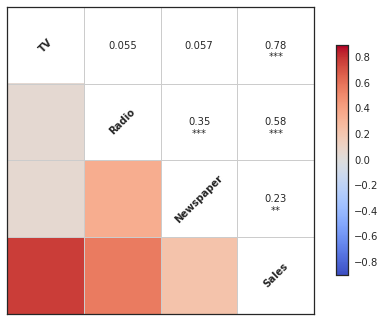

In [142]:
sns.corrplot(advertising)

### Figure 3.5 - Multiple Linear Regression

In [143]:
regr = skl_lm.LinearRegression()

X = advertising[['Radio', 'TV']].as_matrix()
y = advertising.Sales

regr.fit(X,y)
print(regr.coef_)
print(regr.intercept_)

[ 0.18799423  0.04575482]
2.92109991241


In [144]:
# What are the min/max values of Radio & TV?
advertising[['Radio', 'TV']].describe()

            Radio          TV
count  200.000000  200.000000
mean    23.264000  147.042500
std     14.846809   85.854236
min      0.000000    0.700000
25%      9.975000   74.375000
50%     22.900000  149.750000
75%     36.525000  218.825000
max     49.600000  296.400000

In [145]:
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(regr.intercept_ + B1[i,j]*regr.coef_[0] + B2[i,j]*regr.coef_[1])

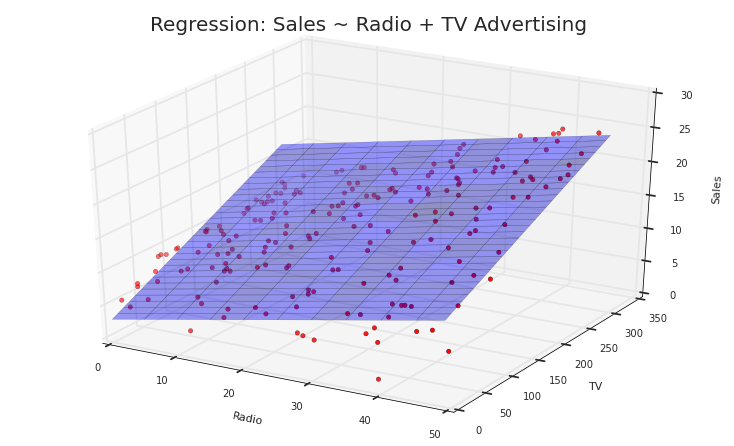

In [146]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: Sales ~ Radio + TV Advertising', fontsize=20)

ax1 = axes3d.Axes3D(fig)

ax1.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax1.scatter3D(advertising.Radio, advertising.TV, advertising.Sales, c='r')

ax1.set_xlabel('Radio')
ax1.set_xlim(0,50)
ax1.set_ylabel('TV')
ax1.set_ylim(ymin=0)
ax1.set_zlabel('Sales')

### Figure 3.6

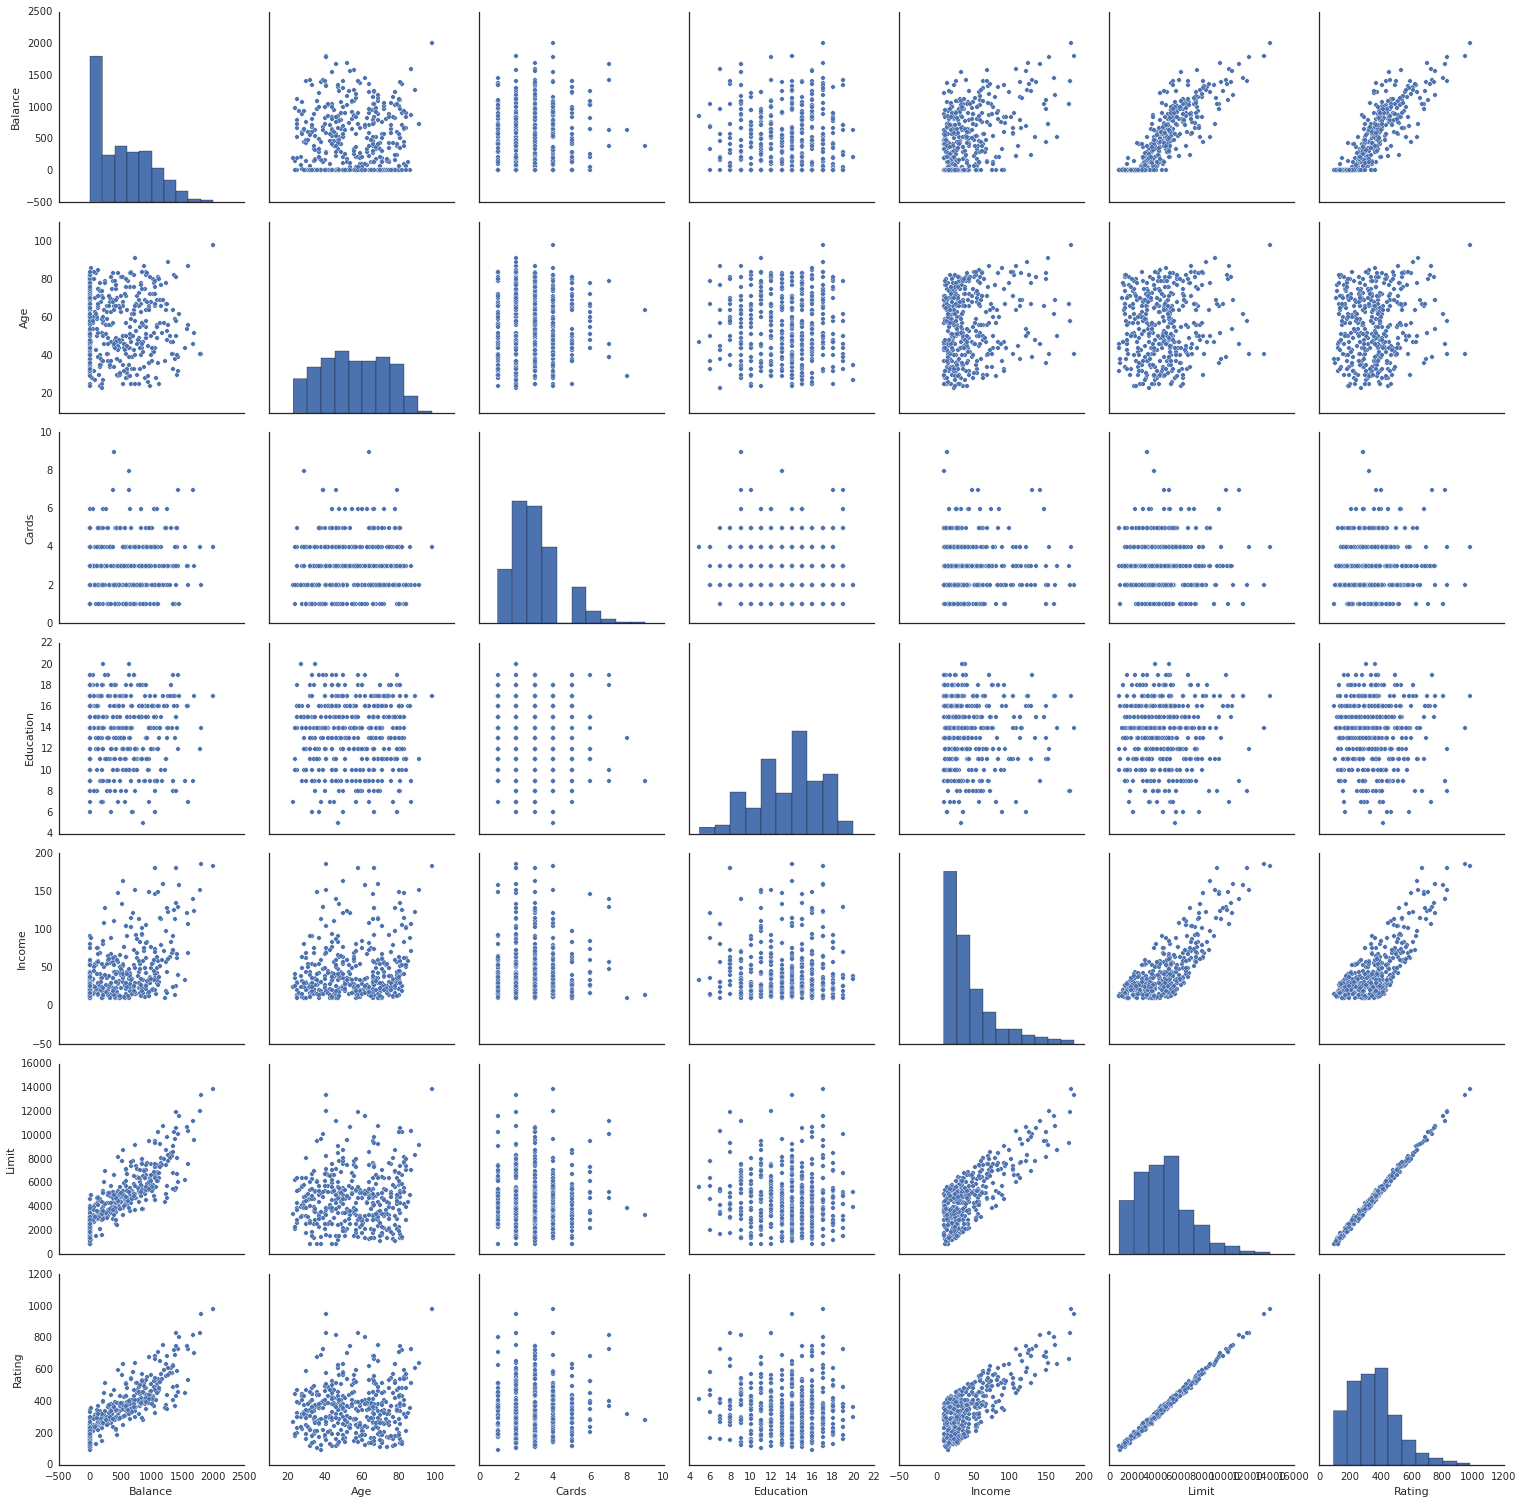

In [147]:
sns.pairplot(credit[['Balance','Age','Cards','Education','Income','Limit','Rating']])

###  Table 3.7

In [148]:
est = smf.ols('Balance ~ Gender', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,509.8031,33.128,15.389,0.000,444.675 574.931
Gender[T.Female],19.7331,46.051,0.429,0.669,-70.801 110.267


### Table 3.8

In [149]:
est = smf.ols('Balance ~ Ethnicity', credit).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.04344
Date:                Thu, 27 Aug 2015   Prob (F-statistic):              0.957
Time:                        22:55:06   Log-Likelihood:                -3019.3
No. Observations:                 400   AIC:                             6045.
Df Residuals:                     397   BIC:                             6057.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                531.0000     46.319     11.464      0.000       439.939   622.061
Ethnicity[T.Asian]       -18.6863     65.021     -0.287      0.774      -146.515   109.142
Ethnicity[T.Caucasian]   -12.5025     56.681     -0.221      0.826      -123.935    98.930
==============================================================================
Omnibus:                       28.829   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.395
Skew:                           0.581   Prob(JB):                     1.13e-06
Kurtosis:                       2.460   Cond. No.                         4.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Table 3.9 - Interaction Variables

In [150]:
est = smf.ols('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,6.7502,0.248,27.233,0.000,6.261 7.239
TV,0.0191,0.002,12.699,0.000,0.016 0.022
Radio,0.0289,0.009,3.241,0.001,0.011 0.046
TV:Radio,0.0011,5.24e-05,20.727,0.000,0.001 0.001


### Figure 3.7 - Interaction between qualitative and quantative variables

In [151]:
est1 = smf.ols('Balance ~ Income + Student2', credit).fit()
regr1 = est1.params
est2 = smf.ols('Balance ~ Income + Income*Student2', credit).fit()
regr2 = est2.params

print('Regression 1')
print(regr1)
print('\nRegression 2')
print(regr2)

Regression 1
Intercept    211.142964
Income         5.984336
Student2     382.670539
dtype: float64

Regression 2
Intercept          200.623153
Income               6.218169
Student2           476.675843
Income:Student2     -1.999151
dtype: float64


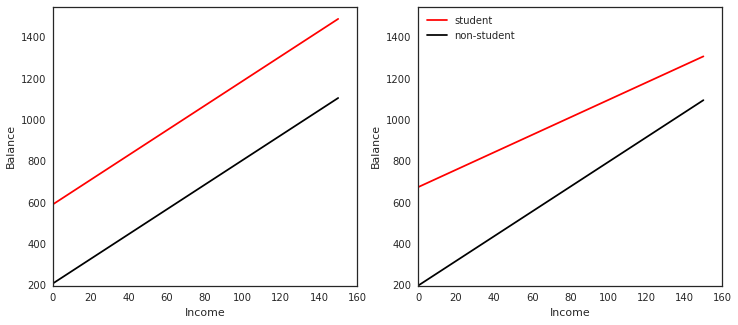

In [152]:
income = np.linspace(0,150)
student1 = np.linspace(regr1['Intercept']+regr1['Student2'],
                       regr1['Intercept']+regr1['Student2']+150*+regr1['Income'])
student2 = np.linspace(regr2['Intercept']+regr2['Student2'],
                       regr2['Intercept']+regr2['Student2']+150*(regr2['Income']+regr2['Income:Student2']))
non_student1 =  np.linspace(regr1['Intercept'], 150*regr1['Income']+regr1['Intercept'])
non_student2 =  np.linspace(regr2['Intercept'], 150*regr1['Income']+regr2['Intercept'])

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(income, student1, 'r', income, non_student1, 'k')
ax2.plot(income, student2, 'r', income, non_student2, 'k')
ax2.legend(['student', 'non-student'], loc=2)

for ax in fig.axes:
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)

### Figure 3.8 - Non-linear relationships

In [153]:
auto['horsepower2'] = auto.horsepower**2
auto.head(3)

   mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0   18          8           307         130    3504          12.0    70   
1   15          8           350         165    3693          11.5    70   
2   18          8           318         150    3436          11.0    70   

   origin                       name  horsepower2  
0       1  chevrolet chevelle malibu        16900  
1       1          buick skylark 320        27225  
2       1         plymouth satellite        22500  

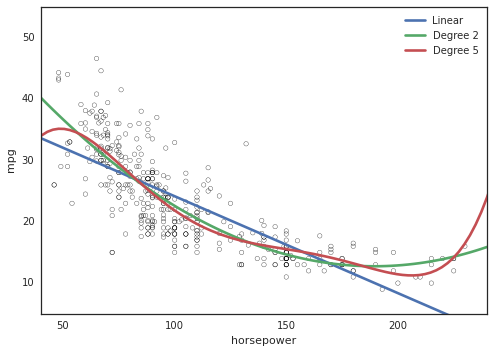

In [155]:
plt.scatter(auto.horsepower, auto.mpg, facecolor='None', edgecolor='k') 
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Linear', scatter=False)
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 2', order=2, scatter=False)
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 5', order=5, scatter=False)
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240);

### Table 3.10

In [156]:
est = smf.ols('mpg ~ horsepower + horsepower2', auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
Intercept,56.9001,1.800,31.604,0.000,53.360 60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527 -0.405
horsepower2,0.0012,0.000,10.080,0.000,0.001 0.001


### Figure 3.14

In [157]:
regr1 = skl_lm.LinearRegression()

X = auto.horsepower.reshape(-1,1)
y = auto.mpg

regr1.fit(X, y)
auto['pred1'] = regr1.predict(X)
auto['resid1'] = auto.mpg - auto.pred1

regr2 = skl_lm.LinearRegression()
X2 = auto[['horsepower', 'horsepower2']].as_matrix()

regr2.fit(X2, y)
auto['pred2'] = regr2.predict(X2)
auto['resid2'] = auto.mpg - auto.pred2

In [158]:
mean_squared_error(auto.mpg, auto.pred2)

18.984768907617216

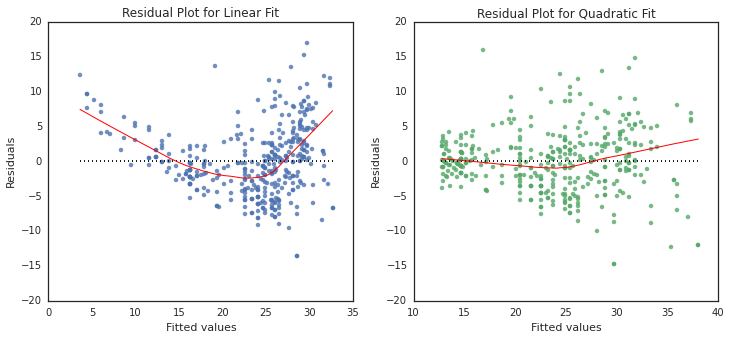

In [159]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
sns.regplot(auto.pred1, auto.resid1, lowess=True, line_kws={'color':'r', 'lw':1}, ax=ax1)
ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0], xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
ax1.set_title('Residual Plot for Linear Fit')

sns.regplot(auto.pred2, auto.resid2, lowess=True, line_kws={'color':'r', 'lw':1}, ax=ax2)
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0], xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')    

### Figure 3.14

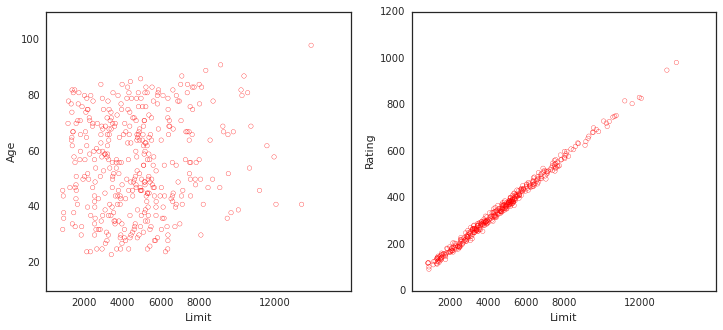

In [160]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.scatter(credit.Limit, credit.Age, facecolor='None', edgecolor='r')
ax1.set_ylabel('Age')
ax2.scatter(credit.Limit, credit.Rating, facecolor='None', edgecolor='r')
ax2.set_ylabel('Rating')

for ax in fig.axes:
    ax.set_xlabel('Limit')
    ax.set_xticks([2000,4000,6000,8000,12000])

### Figure 3.15

In [161]:
# Regression coefficients and corresponding RSS
regr1 = skl_lm.LinearRegression()

X = credit[['Age', 'Limit']].as_matrix()
X2 = credit[['Rating', 'Limit']].as_matrix()
y = credit.Balance

regr1.fit(scale(X.astype('float'), with_std=False), y)
print('Age/Limit\n',regr1.intercept_)
print(regr1.coef_)

regr2 = skl_lm.LinearRegression()
regr2.fit(scale(X2.astype('float'), with_std=False), y)
print('\nRating/Limit\n',regr2.intercept_)
print(regr2.coef_)

Age/Limit
 520.015
[-2.29148553  0.17336497]

Rating/Limit
 520.015
[ 2.20167217  0.02451438]


In [162]:
# Create grid coordinates for plotting
B_Age = np.linspace(regr1.coef_[0]-3, regr1.coef_[0]+3, 100)
B_Limit = np.linspace(regr1.coef_[1]-0.02, regr1.coef_[1]+0.02, 100)

B_Rating = np.linspace(regr2.coef_[0]-3, regr2.coef_[0]+3, 100)
B_Limit2 = np.linspace(regr2.coef_[1]-0.2, regr2.coef_[1]+0.2, 100)

X1, Y1 = np.meshgrid(B_Limit, B_Age, indexing='xy')
X2, Y2 = np.meshgrid(B_Limit2, B_Rating, indexing='xy')
Z1 = np.zeros((B_Age.size,B_Limit.size))
Z2 = np.zeros((B_Rating.size,B_Limit2.size))

Limit_scaled = scale(credit.Limit.astype('float'), with_std=False)
Age_scaled = scale(credit.Age.astype('float'), with_std=False)
Rating_scaled = scale(credit.Rating.astype('float'), with_std=False)

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z1):
    Z1[i,j] =((y - (regr1.intercept_ + X1[i,j]*Limit_scaled + Y1[i,j]*Age_scaled))**2).sum()/1000000
    
for (i,j),v in np.ndenumerate(Z2):
    Z2[i,j] =((y - (regr2.intercept_ + X2[i,j]*Limit_scaled+Y2[i,j]*Rating_scaled))**2).sum()/1000000

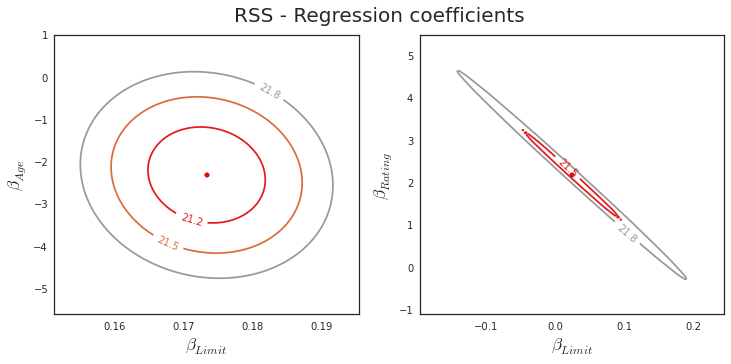

In [163]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
    
# Left plot
CS = ax1.contour(X1, Y1, Z1, cmap=cm.Set1, levels=[21.25, 21.5, 21.8])
ax1.scatter(regr1.coef_[1], regr1.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax1.set_ylabel(r'$\beta_{Age}$', fontsize=17)

# Right plot
CS = ax2.contour(X2, Y2, Z2, cmap=cm.Set1, levels=[21.5, 21.8])
ax2.scatter(regr2.coef_[1], regr2.coef_[0], c='r', label=min_RSS)
ax2.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax2.set_ylabel(r'$\beta_{Rating}$', fontsize=17)
ax2.set_xticks([-0.1, 0, 0.1, 0.2])

for ax in fig.axes:
    ax.set_xlabel(r'$\beta_{Limit}$', fontsize=17)

### Variance Inflation Factor (page 102)

In [ ]:
est_Age = smf.ols('Age ~ Rating + Limit', credit).fit()
est_Rating = smf.ols('Rating ~ Age + Limit', credit).fit()
est_Limit = smf.ols('Limit ~ Age + Rating', credit).fit()

print(1/(1-est_Age.rsquared))
print(1/(1-est_Rating.rsquared))
print(1/(1-est_Limit.rsquared))